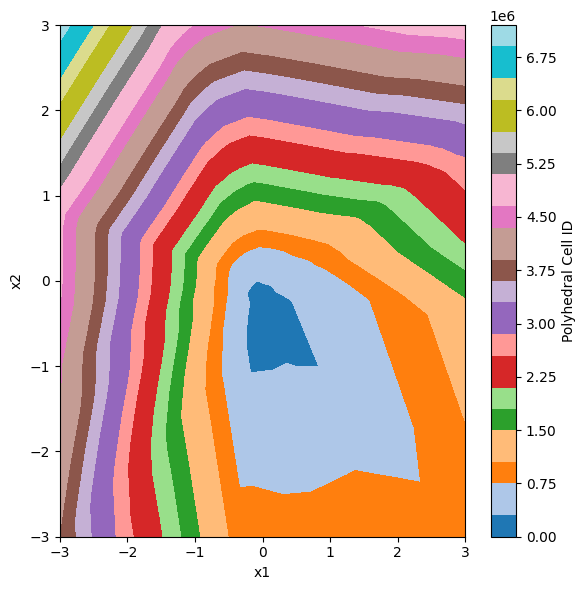

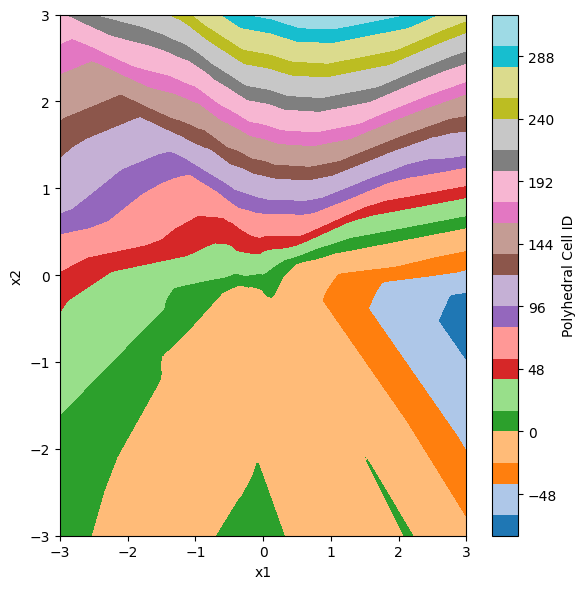

In [27]:
# Construct a 4-quadrant dataset, train DeepReLUNet, and visualize feat space

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# ----- Model definition (reuse) -----
class DeepReLUNet(nn.Module):
    def __init__(self, depth=2, width=20, num_classes=4):
        super().__init__()
        layers = []
        layers.append(nn.Linear(2, width))
        layers.append(nn.ReLU())
        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())
        self.feature_net = nn.Sequential(*layers)
        self.classifier = nn.Linear(width, num_classes)

    def forward(self, x, return_feat=False):
        h = self.feature_net(x)
        out = self.classifier(h)
        if return_feat:
            return out, h
        return out


def init_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean=0.0, std=1.0)
            nn.init.uniform_(m.bias, -0.5, 0.5)


# ----- 1. Construct 4-quadrant dataset -----
def sample_quadrant_data(n_per_quad=5000):
    xs, ys, labels = [], [], []
    for i, (sx, sy) in enumerate([(1, 1), (-1, 1), (-1, -1), (1, -1)]):
        x = torch.randn(n_per_quad, 2) * 0.3
        x[:, 0] += sx
        x[:, 1] += sy
        y = torch.full((n_per_quad,), i)
        xs.append(x)
        labels.append(y)
    X = torch.cat(xs, dim=0)
    Y = torch.cat(labels, dim=0)
    return X, Y


X, Y = sample_quadrant_data()

# ----- 2. Train the network -----
torch.manual_seed(0)
model = DeepReLUNet(depth=2, width=20, num_classes=4)
init_weights(model)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(1000):
    optimizer.zero_grad()
    logits = model(X)
    loss = criterion(logits, Y)
    loss.backward()
    optimizer.step()


# ----- 3. Visualize feat space -----
def sample_grid(n=300, lim=3.0):
    xs = np.linspace(-lim, lim, n)
    ys = np.linspace(-lim, lim, n)
    xx, yy = np.meshgrid(xs, ys)
    pts = np.stack([xx.ravel(), yy.ravel()], axis=1)
    return xx, yy, torch.tensor(pts, dtype=torch.float32)


def compute_cell_ids(model, x):
    with torch.no_grad():
        _, feat = model(x, return_feat=True)
    # 把 activation pattern 映射为整数 hash
    powers = 2 ** torch.arange(feat.shape[1])
    cell_id = (feat * powers).sum(dim=1)
    return cell_id.cpu().numpy()


xx, yy, pts = sample_grid()
cell_ids = compute_cell_ids(model, pts)
cell_ids = cell_ids.reshape(xx.shape)
# cell_hash = compute_cell_ids(model, pts)
# cell_hash = np.array(cell_hash).reshape(xx.shape)
plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, cell_ids, levels=50, cmap="tab20")
plt.colorbar(label="Polyhedral Cell ID")
plt.xlabel("x1")
plt.ylabel("x2")
plt.tight_layout()
plt.show()


def compute_cell_ids_out(model, x):
    with torch.no_grad():
        out, feat = model(x, return_feat=True)
    # 把 activation pattern 映射为整数 hash
    powers = 2 ** torch.arange(out.shape[1])
    cell_id = (out * powers).sum(dim=1)
    return cell_id.cpu().numpy()


xx, yy, pts = sample_grid()
cell_ids = compute_cell_ids_out(model, pts)
cell_ids = cell_ids.reshape(xx.shape)
# cell_hash = compute_cell_ids(model, pts)
# cell_hash = np.array(cell_hash).reshape(xx.shape)
plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, cell_ids, levels=50, cmap="tab20")
plt.colorbar(label="Polyhedral Cell ID")
plt.xlabel("x1")
plt.ylabel("x2")
plt.tight_layout()
plt.show()